In [78]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import re
import requests
import seaborn as sns

from db import create_connection
from db import (
    articles,
    services,
    urls
)

In [79]:
connection = create_connection()

# Get data

In [80]:
data = articles.get_articles(connection)

In [81]:
pd.set_option('max_colwidth', 100)
df = pd.DataFrame(data, columns = ['publication_date',
                                   'author',
                                   'title',
                                   'url',
                                   'koronawirus_in_text',
                                   'koronawirus_in_title'])

In [82]:
df.sample(frac = 0.001)

,publication_date,author,title,url,koronawirus_in_text,koronawirus_in_title
5465,NaT,None,None,https://www.se.pl/lublin/fontanna-na-pl-litewskim-zniszczona-kolejny-raz-kto-tym-razem-zdjecia-a...,NaN,NaN
5141,NaT,None,None,https://www.se.pl/lublin/atak-terrorystyczny-w-lublinie-na-szczescie-pozorowany-zdjecia-aa-VVBw-...,NaN,NaN
8388,2020-01-03 11:45:00,Agnieszka Niećko,Lublin: Na autobus poczekamy dłużej. Zarząd Transportu Miejskiego zapowiada zmiany,https://www.se.pl/lublin/na-autobus-poczekamy-dluzej-w-lublinie-zarzad-transportu-miejskiego-zap...,0.0,0.0
1649,NaT,None,None,https://www.se.pl/lublin/trafil-na-izbe-wytrzezwien-rano-juz-nie-zyl-tajemnicza-smierc-37-latka-...,NaN,NaN
3693,NaT,None,None,https://www.se.pl/lublin/pielgrzymka-lublin-jasna-gora-pielgrzymka-do-czestochowy-zdjecia-pielgr...,NaN,NaN
380,2020-06-27 21:56:00,Mucha,Komendant policji w Puławach oddał krew i złapał kościelnego złodzieja,https://lublin.se.pl/komendant-policji-w-pulawach-oddal-krew-i-zlapal-koscielnego-zlodzieja-aa-j...,0.0,0.0
6873,NaT,None,None,https://www.se.pl/lublin/nowe-ulice-w-lublinie-bliska-i-dereckiego-miasto-sie-rozwija-mapy-aa-RH...,NaN,NaN
777,2020-02-21 08:44:00,mt,Lubelskie: Ciało NOWORODKA zakopane w ogródku. Matka UNIKNIE KARY?,https://www.se.pl/lublin/lubelskie-cialo-noworodka-zakopane-w-ogrodku-matka-uniknie-kary-aa-GHab...,0.0,0.0


# Clean data

### initial data check, organize and clearing

In [83]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8393 entries, 0 to 8392
Data columns (total 6 columns):
publication_date        1489 non-null datetime64[ns]
author                  1489 non-null object
title                   1489 non-null object
url                     8393 non-null object
koronawirus_in_text     1489 non-null float64
koronawirus_in_title    1489 non-null float64
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 2.3 MB


In [84]:
df.nunique()

publication_date        1479
author                   124
title                   1486
url                     8393
koronawirus_in_text       33
koronawirus_in_title       2
dtype: int64

In [85]:
df.dropna(inplace=True)
df.shape

(1489, 6)

In [86]:
df['author'] = df['author'].astype('category')
df['koronawirus_in_text'] = df['koronawirus_in_text'].astype('int')
df['koronawirus_in_title'] = df['koronawirus_in_title'].astype('int')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1489 entries, 0 to 8392
Data columns (total 6 columns):
publication_date        1489 non-null datetime64[ns]
author                  1489 non-null category
title                   1489 non-null object
url                     1489 non-null object
koronawirus_in_text     1489 non-null int64
koronawirus_in_title    1489 non-null int64
dtypes: category(1), datetime64[ns](1), int64(2), object(2)
memory usage: 658.0 KB


In [87]:
df.count()

publication_date        1489
author                  1489
title                   1489
url                     1489
koronawirus_in_text     1489
koronawirus_in_title    1489
dtype: int64

### column: publication_day

In [88]:
df.insert(loc=1, column='publication_day', value=df['publication_date'].dt.strftime('%Y-%m-%d'))
df.sample(frac = 0.002)

,publication_date,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title
19,2020-08-12 12:18:00,2020-08-12,Marek Targoński,Lubelskie: Prawie 30 proc. maturzystów OBLAŁO egzamin dojrzałości. Wyniki [MATURA 2020],https://lublin.se.pl/lubelskie-prawie-30-proc-maturzystow-oblalo-egzamin-dojrzalosci-wyniki-matu...,2,0
61,2020-08-05 11:37:00,2020-08-05,Marek Targoński,"Oto NAJBIEDNIEJSZA gmina w Polsce. Leży w woj. lubelskim. „Słońce, ryby i grzyby”",https://lublin.se.pl/oto-najbiedniejsza-gmina-w-polsce-lezy-w-woj-lubelskim-slonce-ryby-i-grzyby...,0,0
205,2020-07-15 14:42:00,2020-07-15,Mariusz Mucha,Świdnik: Koparką na ekspresówkę. Naprawdę PRZESADZIŁ z pośpiechem,https://lublin.se.pl/swidnik-koparka-na-ekspresowke-naprawde-przesadzil-z-pospiechem-aa-5LKX-YKC...,0,0


In [89]:
df.publication_day.value_counts().head()

2020-06-29    28
2020-07-08    26
2020-07-01    25
2020-07-03    22
2020-07-14    21
Name: publication_day, dtype: int64

In [90]:
df['publication_day'].nunique()

219

In [91]:
#df['publication_day'] = df['publication_day'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1489 entries, 0 to 8392
Data columns (total 7 columns):
publication_date        1489 non-null datetime64[ns]
publication_day         1489 non-null object
author                  1489 non-null category
title                   1489 non-null object
url                     1489 non-null object
koronawirus_in_text     1489 non-null int64
koronawirus_in_title    1489 non-null int64
dtypes: category(1), datetime64[ns](1), int64(2), object(3)
memory usage: 755.4 KB


### column: publication_month

In [92]:
df.insert(loc=1, column='publication_month', value=df['publication_date'].dt.strftime('%Y-%m'))
df.sample(frac = 0.001)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title
108,2020-07-28 16:11:00,2020-07,2020-07-28,Karolina Januszek,Rozpoczynają się letnie upały. Gdzie kupić tanie klimatyzatory i wiatraki?,https://lublin.se.pl/rozpoczynaja-sie-letnie-upaly-gdzie-kupic-tanie-klimatyzatory-i-wiatraki-ak...,0,0


In [93]:
df.publication_month.value_counts().head()

2020-07    443
2020-06    214
2020-01    154
2020-05    153
2020-03    147
Name: publication_month, dtype: int64

In [94]:
df['publication_month'].nunique()

8

In [95]:
#df['publication_month'] = df['publication_month'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1489 entries, 0 to 8392
Data columns (total 8 columns):
publication_date        1489 non-null datetime64[ns]
publication_month       1489 non-null object
publication_day         1489 non-null object
author                  1489 non-null category
title                   1489 non-null object
url                     1489 non-null object
koronawirus_in_text     1489 non-null int64
koronawirus_in_title    1489 non-null int64
dtypes: category(1), datetime64[ns](1), int64(2), object(4)
memory usage: 848.5 KB


### column: author

In [96]:
df['author'].value_counts()[:60]

mt                                 335
Mucha                              147
Marek Targoński                    135
Karolina Januszek                   94
MTA                                 80
Mariusz Mucha                       76
Mucha, mta                          55
AP                                  36
OM                                  32
KM                                  26
Bartłomiej Ważny                    23
Monika Kowalewicz                   22
AC                                  20
MK                                  16
Mateusz Kasiak                      16
Michał Michalak                     16
Agnieszka Niećko                    15
gk                                  15
Jacek Werner                        14
EIB                                 13
Sylwia Sitka-Czerniak               13
Artykuł sponsorowany                13
Olka Mazur                          13
maal                                11
Emilia Białecka                     11
RS                       

In [97]:
df['author'] = df['author'].str.lower()
regex_pattern = re.compile(r'.*mt.*', re.I)
df[df['author'].str.contains(regex_pattern)].count()

publication_date        514
publication_month       514
publication_day         514
author                  514
title                   514
url                     514
koronawirus_in_text     514
koronawirus_in_title    514
dtype: int64

In [165]:
df['author'] = df['author'].replace(['mt', 'mt; wideo: Tygodnik Zamojski', 'gał'],'marek targoński')
# df['author'] = df['author'].replace(['Mucha', 'mucha'],'Mariusz Mucha')
# df['author'] = df['author'].replace(['ŁT'],'Łukasz Trybulski')
# df['author'] = df['author'].replace(['Mateusz Kasiak (Radio Eska)'],'Mateusz Kasiak')
# df['author'] = df['author'].replace(['KaJa'],'Karolina Januszek')
# df['author'] = df['author'].replace(['RS'],'Rafał Strzelec')
# df['author'] = df['author'].replace(['gk'],'Grzegorz Kluczyński')
# df['author'] = df['author'].replace([''],'Nieznany')

# regex_pattern = re.compile(r'(.*,.*|.*/.*|Redakcja ESKA INFO|Nieznany|Akcja partnerska)', re.I)
# df['author'] = df['author'].replace(regex_pattern,'Więcej autorów lub nieznany')

regex_pattern = re.compile(r'.*mt.*', re.I)
df['author'] = df['author'].replace(regex_pattern,'marek targoński')

df['author'].value_counts()[:50]

marek targoński                        651
mucha                                  148
karolina januszek                       94
mariusz mucha                           76
ap                                      36
om                                      32
km                                      26
bartłomiej ważny                        23
monika kowalewicz                       22
ac                                      20
maal                                    17
mateusz kasiak                          16
michał michalak                         16
mk                                      16
agnieszka niećko                        15
gk                                      15
jacek werner                            14
eib                                     13
sylwia sitka-czerniak                   13
artykuł sponsorowany                    13
olka mazur                              13
emilia białecka                         11
rs                                      10
kaja       

In [166]:
df['author'] = df['author'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1489 entries, 0 to 8392
Data columns (total 10 columns):
publication_date              1489 non-null datetime64[ns]
publication_month             1489 non-null object
publication_day               1489 non-null object
author                        1489 non-null category
title                         1489 non-null object
url                           1489 non-null object
koronawirus_in_text           1489 non-null int64
koronawirus_in_title          1489 non-null int64
koronawirus_anywhere          1489 non-null int64
koronawirus_anywhere_count    1489 non-null int64
dtypes: category(1), datetime64[ns](1), int64(4), object(4)
memory usage: 866.9 KB


### column: koronawiorus_text

In [167]:
# df.loc[[919, 1979, 1965], 'koronawirus_in_text'] = 0

### column: koronawiorus_anywhere_sum

In [168]:
df['koronawirus_anywhere'] = 0
df['koronawirus_anywhere'] = df['koronawirus_in_text'] + df['koronawirus_in_title']
# df.loc[df.koronawirus_anywhere > 0, 'koronawirus_anywhere'] = 1
df.head(1)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere,koronawirus_anywhere_count
0,2020-08-17 13:40:00,2020-08,2020-08-17,karolina januszek,Wyprawka szkolna 2020. Jak tanio skompletować na nowy rok szkolny?,https://lublin.se.pl/wyprawka-szkolna-2020-jak-tanio-skompletowac-na-nowy-rok-szkolny-ak-fiix-y7...,0,0,0,0


### column: koronawiorus_anywhere_count

In [169]:
df['koronawirus_anywhere_count'] = 0
df['koronawirus_anywhere_count'] = (df['koronawirus_in_text'] + df['koronawirus_in_title']) / (df['koronawirus_in_text'] + df['koronawirus_in_title'])
df['koronawirus_anywhere_count'] = df['koronawirus_anywhere_count'].fillna(0).astype('int')
df.head(3)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere,koronawirus_anywhere_count
0,2020-08-17 13:40:00,2020-08,2020-08-17,karolina januszek,Wyprawka szkolna 2020. Jak tanio skompletować na nowy rok szkolny?,https://lublin.se.pl/wyprawka-szkolna-2020-jak-tanio-skompletowac-na-nowy-rok-szkolny-ak-fiix-y7...,0,0,0,0
1,2020-08-17 12:30:00,2020-08,2020-08-17,karolina januszek,"Popularna promocja znowu w Lidlu. Zobacz, co możesz kupić",https://lublin.se.pl/popularna-promocja-znowu-w-lidlu-zobacz-co-mozesz-kupic-ak-qjqc-MfwC-D5DE.html,0,0,0,0
2,2020-08-17 11:54:00,2020-08,2020-08-17,karolina januszek,Uważaj na swoje pieniądze. Oszuści uaktywnili się podczas pandemii,https://lublin.se.pl/uwazaj-na-swoje-pieniadze-oszusci-uaktywnili-sie-podczas-pandemii-ak-2VBF-H...,3,1,4,1


# Project

### Pierwsze opublikowane artykuły o covid

In [170]:
covid_articles = df.sort_values(by=['koronawirus_in_title', 'publication_date'], ascending=[False, True])
covid_articles[['publication_date', 'author', 'title', 'url']].head(8)

,publication_date,author,title,url
8337,2020-01-29 15:07:00,mpgt,"Koronawirus na Lubelszczyźnie? Sześć osób trafiło na badania! [AKTUALIZACJA, AUDIO]",https://www.se.pl/lublin/koronawirus-na-lubelszczyznie-lecieli-samolotem-z-pasazerami-z-chin-tra...
8331,2020-01-31 10:46:00,marek targoński,Koronawirus z Chin: Gdzie jest? Sprawdź swój region! Lubelskie jest bezpieczne? [MAPA],https://www.se.pl/lublin/koronawirus-z-chin-gdzie-jest-sprawdz-swoj-region-lubelskie-jest-bezpie...
8324,2020-02-05 16:54:00,ac,Koronawirus w Lublinie? Mężczyzna zgłosił się z do kliniki chorób zakaźnych! [AKTUALIZACJA],https://www.se.pl/lublin/koronawirus-w-lublinie-mezczyzna-zglosil-sie-z-objawami-do-kliniki-chor...
806,2020-02-08 22:25:00,marek targoński,KORONAWIRUS w Lublinie? Znamy wyniki badań! NOWE INFORMACJE [RELACJA],https://www.se.pl/lublin/koronawirus-w-lublinie-pacjent-trafil-do-szpitala-trwaja-badania-audio-...
8296,2020-02-26 09:33:00,marek targoński,Koronawirus w Lubelskiem? Wrócili z Włoch – 27 osób pod lupą sanepidu. „Zwiększone ryzyko” [AKTU...,https://www.se.pl/lublin/koronawirus-w-lubelskiem-wrocili-z-wloch-27-osob-pod-lupa-sanepidu-zwie...
8295,2020-02-26 13:31:00,marek targoński,Koronawirus w Lublinie? Uczelnia zawiesza rekrutację cudzoziemców. „Wszyscy się boimy”,https://www.se.pl/lublin/koronawirus-w-lublinie-uczelnia-zawiesza-rekrutacje-cudzoziemcow-wszysc...
763,2020-02-26 14:58:00,marek targoński,"Koronawirus w Lubelskiem? Dwie osoby w szpitalu! Trwają badania [AKTUALIZACJA, AUDIO]",https://www.se.pl/lublin/koronawirus-na-lubelszczyznie-dwie-osoby-w-szpitalu-trwaja-badania-aa-a...
8294,2020-02-27 07:42:00,marek targoński,Koronawirus. Gdzie zgłosić się z objawami w Lublinie? Oddziały zakaźne w Lubelskiem [ADRESY],https://www.se.pl/lublin/koronawirus-gdzie-zglosic-sie-z-objawami-w-lublinie-oddzialy-zakazne-w-...


### łączna ilość artykułów mających w tytule słowo z grupy "koronawirus"

In [171]:
# df.koronawirus_in_title.sum()

df.groupby('koronawirus_in_title').count()

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_anywhere,koronawirus_anywhere_count
koronawirus_in_title,,,,,,,,,
0,1138,1138,1138,1138,1138,1138,1138,1138,1138
1,351,351,351,351,351,351,351,351,351


### średnia ilość artykułów mających w tytule słowo z grupy "koronawirus"

In [172]:
df.koronawirus_in_title.mean()

0.23572867696440564

### Ilość opublikowanych artykułów ze słowem "k" w tytule w każdym miesiącu + porównanie

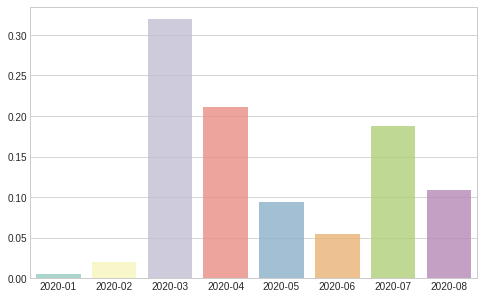

In [173]:
df_with_koronawirus_in_title = df.where(df["koronawirus_in_title"] > 0).dropna()
publication_month_with_koronawirus_in_title_count = df_with_koronawirus_in_title.publication_month.astype('category').value_counts(normalize=True)
plt.figure(figsize=(8, 5))
sns.barplot(publication_month_with_koronawirus_in_title_count.index, publication_month_with_koronawirus_in_title_count.values, alpha=0.8)
plt.show()

In [174]:
df_with_koronawirus_in_title.groupby('publication_month').count()

,publication_date,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere,koronawirus_anywhere_count
publication_month,,,,,,,,,
2020-01,2,2,2,2,2,2,2,2,2
2020-02,7,7,7,7,7,7,7,7,7
2020-03,112,112,112,112,112,112,112,112,112
2020-04,74,74,74,74,74,74,74,74,74
2020-05,33,33,33,33,33,33,33,33,33
2020-06,19,19,19,19,19,19,19,19,19
2020-07,66,66,66,66,66,66,66,66,66
2020-08,38,38,38,38,38,38,38,38,38


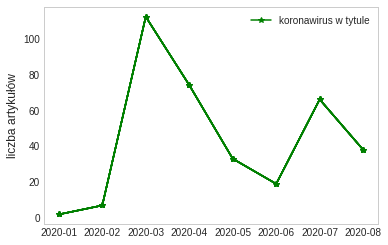

In [175]:
df_with_koronawirus_in_title = df.where(df["koronawirus_in_title"] > 0).dropna()
# plt.style.use('ggplot')
# plt.style.use('dark_background')
#plt.style.use('seaborn-whitegrid')
plt.plot(df_with_koronawirus_in_title.groupby('publication_month').count(),
         color='g',
        marker='*')
plt.ylabel("liczba artykułów")
plt.legend(["koronawirus w tytule"])
# plt.annotate(["2", (0, 8)], ["7", (1.2, 2)])
plt.grid()
plt.show()

### Łączna ilość artykułów mających w tekście słowo z grupy "koronawirus"

In [176]:
koronawirus_in_text_true = df['koronawirus_in_text'] > 0
df['koronawirus_in_text'][koronawirus_in_text_true].count()

555

In [177]:
koronawirus_in_text_true.mean()

0.37273337810611146

### Ilość opublikowanych artykułów ze słowem "k" w tekście w każdym miesiącu

In [178]:
df_with_koronawirus_in_text = df.where(df["koronawirus_in_text"] > 0).dropna()
df_with_koronawirus_in_text.head(1)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere,koronawirus_anywhere_count
2,2020-08-17 11:54:00,2020-08,2020-08-17,karolina januszek,Uważaj na swoje pieniądze. Oszuści uaktywnili się podczas pandemii,https://lublin.se.pl/uwazaj-na-swoje-pieniadze-oszusci-uaktywnili-sie-podczas-pandemii-ak-2VBF-H...,3.0,1.0,4.0,1.0


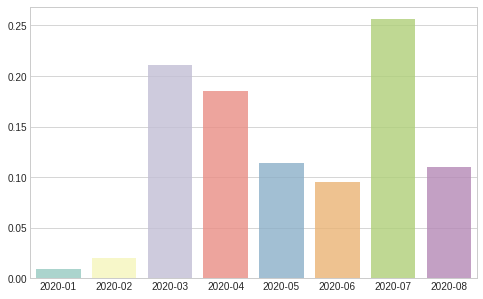

In [179]:
publication_month_with_koronawirus_in_text_count = df_with_koronawirus_in_text.publication_month.astype('category').value_counts(normalize=True)
plt.figure(figsize=(8, 5))
sns.barplot(publication_month_with_koronawirus_in_text_count.index, publication_month_with_koronawirus_in_text_count.values, alpha=0.8)
plt.show()

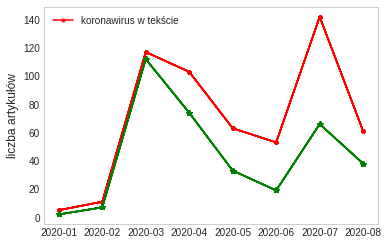

In [180]:
a = plt.plot(df_with_koronawirus_in_text.groupby('publication_month').count(),
        color='r',
        marker='.')

b = plt.plot(df_with_koronawirus_in_title.groupby('publication_month').count(),
        color='g',
        marker='*',
            label='b')

plt.ylabel("liczba artykułów")
plt.grid()
plt.legend(a, ["koronawirus w tekście"])
plt.show()

In [181]:
df_with_koronawirus_in_text.groupby('publication_month').count()

,publication_date,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere,koronawirus_anywhere_count
publication_month,,,,,,,,,
2020-01,5,5,5,5,5,5,5,5,5
2020-02,11,11,11,11,11,11,11,11,11
2020-03,117,117,117,117,117,117,117,117,117
2020-04,103,103,103,103,103,103,103,103,103
2020-05,63,63,63,63,63,63,63,63,63
2020-06,53,53,53,53,53,53,53,53,53
2020-07,142,142,142,142,142,142,142,142,142
2020-08,61,61,61,61,61,61,61,61,61


### Artykuły o koronawirusie bez słów z grupy covid w tytule

In [55]:
title_false = df['koronawirus_in_title'] == 0
text_true = df['koronawirus_in_text'] > 0
publication_month_07 = df['publication_month'] == "2020-07"

df_title_false_and_text_true = df[title_false & text_true & publication_month_07]

df_title_false_and_text_true.sort_values(by='koronawirus_in_text', ascending=False)[:50]

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
106,2020-07-28 17:28:00,2020-07,2020-07-28,karolina januszek,Zakaz handlu tymczasowo zniesiony? Jest projekt,https://lublin.se.pl/zakaz-handlu-tymczasowo-zniesiony-jest-projekt-ak-UDmc-xk46-WKyr.html,12,0,12
349,2020-07-01 07:42:00,2020-07,2020-07-01,bartłomiej ważny,"Startuje Słoneczny Wrotków nad Zalewem Zemborzyckim. Sprawdź, co się zmieniło!",https://lublin.se.pl/startuje-sloneczny-wrotkow-nad-zalewem-zemborzyckim-sprawdz-co-sie-zmienilo...,12,0,12
252,2020-07-10 10:01:00,2020-07,2020-07-10,maal,Fundacja Poczty Polskiej pomaga nie tylko pocztowcom,https://lublin.se.pl/fundacja-poczty-polskiej-pomaga-nie-tylko-pocztowcom-ak-mhyB-eDys-5KSt.html,11,0,11
7904,2020-07-24 17:07:00,2020-07,2020-07-24,kaja,Żabka przekazała 3 mln złotych polskim szpitalom. Wszystko dzięki klientom sieci,https://lublin.se.pl/zabka-przekazala-3-mln-zlotych-polskim-szpitalom-wszystko-dzieki-klientom-s...,11,0,11
7983,2020-07-09 18:24:00,2020-07,2020-07-09,maal,Obowiązkowe mierzenie temperatury pracownikom w Polsce! Ministerstwo reaguje,https://lublin.se.pl/obowiazkowe-mierzenie-temperatury-pracownikom-w-polsce-ministerstwo-reaguje...,9,0,9
155,2020-07-22 15:39:00,2020-07,2020-07-22,karolina januszek,Zmiany w zakazie handlu. Jest nowy pomysł,https://lublin.se.pl/zmiany-w-zakazie-handlu-jest-nowy-pomysl-ak-2SVz-XDkR-RuTM.html,6,0,6
179,2020-07-20 13:30:00,2020-07,2020-07-20,karolina januszek,Koniec pracy zdalnej. Jak przygotować firmę na powrót pracowników?,https://lublin.se.pl/koniec-pracy-zdalnej-jak-przygotowac-firme-na-powrot-pracownikow-ak-ftj7-XG...,5,0,5
161,2020-07-22 12:13:00,2020-07,2020-07-22,karolina januszek,Minister Finansów o deficycie. Padła gigantyczna kwota,https://lublin.se.pl/minister-finansow-o-deficycie-padla-gigantyczna-kwota-ak-BwaP-W8ob-8aQ8.html,5,0,5
319,2020-07-03 14:20:00,2020-07,2020-07-03,karolina januszek,Primark w Polsce. Co dalej z otwarciem sklepu w Warszawie?,https://lublin.se.pl/primark-w-polsce-co-dalej-z-otwarciem-sklepu-w-warszawie-ak-7vbs-ADkt-xaho....,5,0,5
8022,2020-07-03 15:34:00,2020-07,2020-07-03,om,Studenci z Lublina zaprojektowali wyjątkowy bolid i wygrali konkurs dla konstruktorów [WIDEO],https://lublin.se.pl/studenci-z-lublina-zaprojektowali-wyjatkowy-bolid-i-wygrali-konkurs-dla-kon...,4,0,4


### Łączna ilość artykułów

In [182]:
df.shape[0]

1489

### Dni z  największą liczbą opublikowanych artykułów

In [183]:
df.publication_day.value_counts().head(3)

2020-06-29    28
2020-07-08    26
2020-07-01    25
Name: publication_day, dtype: int64

### Ilość opublikowanych artykułów w każdym miesiącu

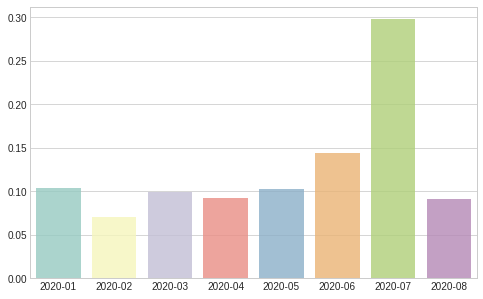

In [184]:
publication_month_count = df.publication_month.astype('category').value_counts(normalize=True)
plt.figure(figsize=(8, 5))
sns.barplot(publication_month_count.index, publication_month_count.values, alpha=0.8)
plt.show()

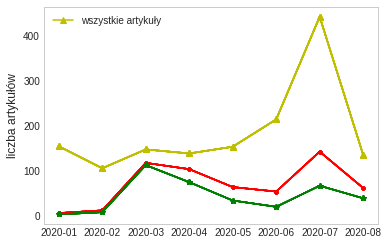

In [185]:
df_with_koronawirus_in_title = df.where(df["koronawirus_in_title"] > 0).dropna()

df_with_koronawirus_in_text = df.where(df["koronawirus_in_text"] > 0).dropna()

c = plt.plot(df.groupby('publication_month').count(),
        color='y',
        marker='^')



a = plt.plot(df_with_koronawirus_in_text.groupby('publication_month').count(),
        color='r',
        marker='.')

b = plt.plot(df_with_koronawirus_in_title.groupby('publication_month').count(),
        color='g',
        marker='*')

plt.ylabel("liczba artykułów")

plt.legend(c, ["wszystkie artykuły"])
plt.grid()
plt.show()

In [186]:
df_with_koronawirus_anywhere = df.where(df["koronawirus_anywhere"] > 0).dropna()
wskaznik = df_with_koronawirus_anywhere.groupby('publication_month').count() / df.groupby('publication_month').count() * 100
wskaznik["publication_date"]

publication_month
2020-01     3.246753
2020-02    10.476190
2020-03    79.591837
2020-04    74.637681
2020-05    41.176471
2020-06    24.766355
2020-07    32.054176
2020-08    45.185185
Name: publication_date, dtype: float64

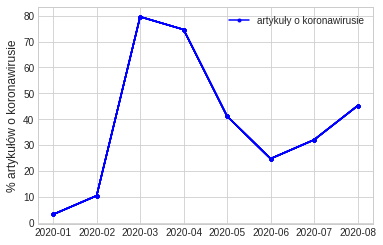

In [187]:

df_with_koronawirus_anywhere = df.where(df["koronawirus_anywhere"] > 0).dropna()

plt.plot((df_with_koronawirus_anywhere.groupby('publication_month').count() / df.groupby('publication_month').count()) * 100,
        color="b",
        marker='.')
plt.ylabel("% artykułów o koronawirusie")
plt.legend(["artykuły o koronawirusie"])

### łączna ilość słów z grupy "koronawirus"

In [188]:
df.koronawirus_in_text.sum()

6152

### Średnia ilość słów z grupy covid na artykuł

In [257]:
koronawirus_in_text_true = df['koronawirus_in_text'] > 0
df[koronawirus_in_text_true].mean()

koronawirus_in_text           11.084685
koronawirus_in_title           0.632432
koronawirus_anywhere          11.717117
koronawirus_anywhere_count     1.000000
dtype: float64

In [259]:
koronawirus_anywhere_true = df['koronawirus_anywhere'] > 0
koronawirus_anywhere_true_count = df.where(koronawirus_anywhere_true).groupby('koronawirus_anywhere').count()[:31]
koronawirus_anywhere_true_count.mean()

555.0

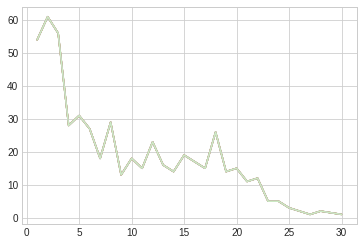

In [251]:
plt.plot(koronawirus_anywhere_true_count)

### Artykuł z największą ilością słów z serii "covid"

In [190]:
# df.loc[df.koronawirus_in_text.idxmax()]

# df['koronawirus_in_text_rank'] = df['koronawirus_in_text'].rank(ascending=False)
# df.sort_values(by='koronawirus_in_text', ascending=False).head(15)

# df.sort_values(by='koronawirus_in_text', ascending=False)[:5]

df.nlargest(n=5, columns='koronawirus_in_text')

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere,koronawirus_anywhere_count
8206,2020-04-16 22:42:00,2020-04,2020-04-16,paweł tabędzki / marek targoński / sylwia sitka-czerniak / konrad marzec,Przełom w walce z koronawirusem?! ARCYWAŻNE zmiany ogłoszone przez rząd. Koronawirus w Polsce [Z...,https://www.se.pl/lublin/liczba-zgonow-i-zakazonych-rosnie-najnowsze-informacje-oraz-statystyki-...,575,1,576,1
8224,2020-04-07 07:00:00,2020-04,2020-04-07,"magdalena jaśkiewicz-stawowczyk, marek targoński",Szokujący bilans koronawirusa w Polsce. Ważne słowa prezydenta Dudy. Groza w UK [ZAPIS RELACJI N...,https://www.se.pl/lublin/koronawirus-w-polsce-dzis-niedziela-palmowa-pierwsza-taka-w-historii-ko...,466,1,467,1
747,2020-03-04 22:25:00,2020-03,2020-03-04,marek targoński,Koronawirus w Polsce! Oto konsekwencje: wzrost cen i wysoki popyt [ZAPIS RELACJI NA ŻYWO],https://www.se.pl/lublin/koronawirus-w-polsce-tytul-relacja-na-zywo-aa-jzM9-R6pH-GAfM.html,325,1,326,1
709,2020-03-19 09:22:00,2020-03,2020-03-19,marek targoński,Koronawirus Lubelskie: COVID-19 na Lubelszczyźnie. Kto i gdzie choruje? Kim są pacjenci?,https://www.se.pl/lublin/koronawirus-lubelskie-covid-19-na-lubelszczyznie-kto-i-gdzie-choruje-ki...,44,1,45,1
806,2020-02-08 22:25:00,2020-02,2020-02-08,marek targoński,KORONAWIRUS w Lublinie? Znamy wyniki badań! NOWE INFORMACJE [RELACJA],https://www.se.pl/lublin/koronawirus-w-lublinie-pacjent-trafil-do-szpitala-trwaja-badania-audio-...,29,1,30,1


### Ilość słów z grupy "koronaworus" w każdym miesiącu

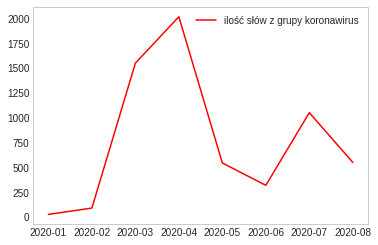

In [191]:
df_with_koronawirus_in_text = df[["koronawirus_in_text", 'publication_month']].where(df["koronawirus_in_text"] > 0).dropna()
plt.plot(
    df_with_koronawirus_in_text.groupby('publication_month').sum(),
    color="r",
    label='ilość słów z grupy koronawirus'
)
plt.grid()
plt.legend()

In [192]:
df_with_koronawirus_in_text.groupby('publication_month').sum()

,koronawirus_in_text
publication_month,
2020-01,27.0
2020-02,91.0
2020-03,1550.0
2020-04,2017.0
2020-05,545.0
2020-06,320.0
2020-07,1051.0
2020-08,551.0


### Autor najwiekszej ilości artykułów ze słowem z grupy "koronawirus" w tytule

In [193]:
df_with_koronawirus_in_title = df.where(df["koronawirus_in_title"] > 0).dropna()
df_with_koronawirus_in_title['author'].value_counts()[:1]

marek targoński    214
Name: author, dtype: int64

### Autor najwiekszej ilości artykułów ze słowem z grupy "koronawirus" w tekście

In [194]:
df_with_koronawirus_in_text = df.where(df["koronawirus_in_text"] > 0).dropna()
df_with_koronawirus_in_text['author'].value_counts()[:1]


marek targoński    278
Name: author, dtype: int64

In [195]:
df.query('author == "marek targoński"').groupby('publication_month').sum()

,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere,koronawirus_anywhere_count
publication_month,,,,
2020-01,7,1,8,1
2020-02,86,6,92,10
2020-03,1200,73,1273,76
2020-04,755,49,804,64
2020-05,416,21,437,40
2020-06,190,12,202,23
2020-07,548,28,576,39
2020-08,403,24,427,25


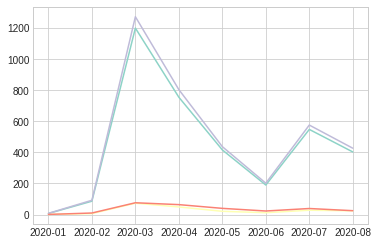

In [200]:
plt.plot(df.query('author == "marek targoński"').groupby('publication_month').sum())

In [224]:
mt = df[df['author'].isin(['marek targoński'])]
del mt['koronawirus_in_title']
del mt['koronawirus_in_text']
del mt['koronawirus_anywhere_count']
mt.sum()

koronawirus_anywhere    3819
dtype: int64

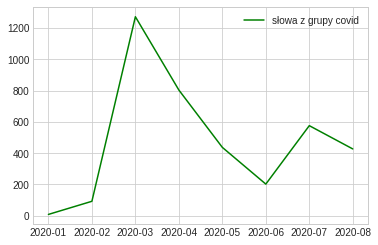

In [244]:
plt.plot(mt.groupby('publication_month').sum(),
        color="g")
plt.legend(["słowa z grupy covid"])

In [245]:
mt = df[df['author'].isin(['marek targoński'])]
del mt['koronawirus_anywhere']
del mt['koronawirus_in_text']
del mt['koronawirus_in_title']
mt.sum()

koronawirus_anywhere_count    278
dtype: int64

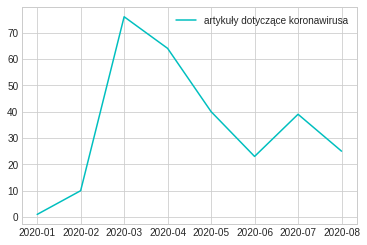

In [246]:
plt.plot(mt.groupby('publication_month').sum(),
        color="c")
plt.legend(["artykuły dotyczące koronawirusa"])